# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

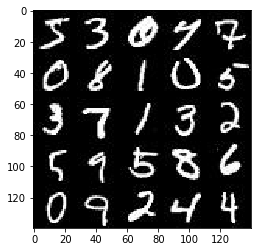

In [11]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

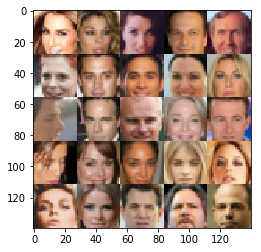

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


C:\ProgramData\Anaconda3\envs\tensorflow-new\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [3]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    fake = tf.placeholder(tf.float32, [None, z_dim])
    learn_rate = tf.placeholder(tf.float32)

    return real, fake, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow-new\\lib\\runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow-new\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow-new\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow-new\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow-new\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOL

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [4]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        #Shape starts as 28*28*3
        x1 = tf.layers.conv2d(inputs=images, 
                              filters=64, 
                              kernel_size=(4, 4), 
                              strides=(2, 2), 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #Apply leaky relu
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.9)
        #Shape now is: 14*14*64
        
        x2 = tf.layers.conv2d(inputs=x1, 
                              filters=128, 
                              kernel_size=(4, 4), 
                              strides=(2, 2), 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #Use batch normalization.
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*alpha)
        x2 = tf.nn.dropout(x2, 0.9)
        #Shape is now: 7*7*128
        
        x3 = tf.layers.conv2d(inputs=x2, 
                              filters=256, 
                              kernel_size=(4, 4), 
                              strides=(2, 2), 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3 * alpha)
        #Shape is now: 4*4*256
        
        #Flatten
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.contrib.layers.fully_connected(flat, 1, activation_fn=None)
        
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [5]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        #Reshape to start deconvolutions.
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        
        x2 = tf.layers.conv2d_transpose(inputs=x1, 
                                        filters=256, 
                                        kernel_size=(4, 4), 
                                        strides=(2,2), 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        #Shape is 8*8*256
        
        x3 = tf.layers.conv2d_transpose(inputs=x2,
                                        filters=128,
                                        kernel_size=(4, 4),
                                        strides=(2, 2),
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)
        #Shape is now 16*16*128
        
        x4 = tf.layers.conv2d_transpose(inputs=x3, 
                                        filters=64, 
                                        kernel_size=(5, 5), 
                                        strides=(2, 2), 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        #Shape is now 32*32*3
        #Final layer to add depth.
        logits = tf.layers.conv2d_transpose(inputs=x4, 
                                            filters=out_channel_dim, 
                                            kernel_size=(5, 5), 
                                            strides=(1, 1), 
                                            padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        logits = tf.image.resize_images(logits, (28, 28))
        #Shape is now 28*28*3
        
        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [6]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_output = generator(input_z, out_channel_dim, is_train=True)
    d_logits_real = discriminator(input_real)
    d_logits_fake = discriminator(g_output, reuse=True)
    
    smooth_val = 0.1
    smooth_factor = (1 - smooth_val)
    
    d_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * smooth_factor))
    
    d_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    
    d_loss= d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
                     tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=disc_vars)
        gen_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=gen_vars)
    
    return disc_optimizer, gen_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_fake, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_fake, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                #Normalize the image data for better convergence with Tanh.
                batch_images = batch_images * 2
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Run Generator optimizer.
                _ = sess.run(g_train_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, learn_rate: learning_rate })
                _ = sess.run(g_train_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, learn_rate: learning_rate })
                
                #Run Optimizer
                _ = sess.run(d_train_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, learn_rate: learning_rate })
                
                if(steps % 10 == 0):
                    train_loss_d = d_loss.eval({input_real: batch_images, input_fake: batch_z })
                    train_loss_g = g_loss.eval({input_fake: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if(steps % 100 == 0):
                    show_generator_output(sess, 9, input_fake, data_shape[3], data_image_mode)
            
            saver.save(sess, './checkpoints/checkpoint.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

[[[[-1.        ]
   [-1.        ]
   [-0.99215686]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-0.98431373]
   [-0.98431373]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-0.99215686]
   [-0.98431373]
   [-0.97647059]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-0.97647059]
   [-0.9137255 ]
   [-0.94509804]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-0.86666667]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.  

   [-1.        ]]]]
[[[[-1.        ]
   [-0.98431373]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-0.99215686]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1

   [-1.        ]]]]
[[[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-0.96078432]
   [-0.96078432]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-0.94509804]
   [-1.        ]
   [-0.97647059]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-0.93725491]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1

   [-1.        ]]]]
[[[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1

   [-1.        ]]]]
[[[[-0.90588236]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-0.94509804]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-0.95294118]
   [-0.97647059]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1

   [-1.        ]]]]
[[[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1

   [-1.        ]]]]
[[[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-0.96078432]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-0.98431373]
   [-0.96862745]
   ..., 
   [-1

   [-1.        ]]]]
[[[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-0.99215686]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-0

   [-1.        ]]]]
[[[[-1.        ]
   [-0.97647059]
   [-0.95294118]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-0.96862745]
   [-0.97647059]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-0.98431373]
   [-0.97647059]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1

   [-1.        ]]]]
Epoch 1/2... Discriminator Loss: 0.7862... Generator Loss: 3.4027
[[[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-0.98431373]
   [-0.96862745]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-0.98431373]
   [-0.96862745]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]



   [-1.        ]]]]
[[[[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]

  ..., 
  [[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]]


 [[[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]

  ..., 
  [[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]]


 [[[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ..., 
   [-1.]
   [-

   [-1.]]]]
[[[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.       

   [-1.        ]]]]
[[[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1

   [-1.        ]]]]
Epoch 1/2... Discriminator Loss: 0.7931... Generator Loss: 2.7734
[[[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]



   [-1.        ]]]]
[[[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1

   [-1.        ]]]]
[[[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1

   [-1.        ]]]]
[[[[-0.97647059]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-0.99215686]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-0.93725491]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-0.85882354]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-0.99215686]
   [-0.88235295]
   ..., 
   [-1

   [-1.        ]]]]
[[[[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  ..., 
  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-1.        ]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]]


 [[[-1.        ]
   [-1.        ]
   [-0.90588236]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-0.94509804]
   [-1.        ]
   [-0.99215686]
   ..., 
   [-1.        ]
   [-1.        ]
   [-1.        ]]

  [[-1.        ]
   [-1.        ]
   [-0.98431373]
   ..., 
   [-1

KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 1.5143
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 1.5993
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 1.9903
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 1.8428
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 2.0399
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 1.7640
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 2.5510
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.7097
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 1.8150
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 1.5759


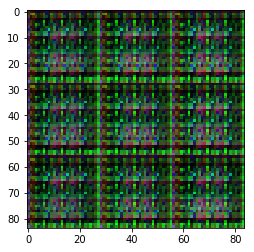

Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 1.2932
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 1.3426
Epoch 1/1... Discriminator Loss: 1.9899... Generator Loss: 1.9283
Epoch 1/1... Discriminator Loss: 1.8730... Generator Loss: 1.7050
Epoch 1/1... Discriminator Loss: 1.8780... Generator Loss: 1.8105
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 1.6193
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 2.0242
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 1.2755


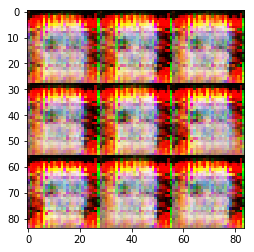

Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 2.0580
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 2.0754
Epoch 1/1... Discriminator Loss: 1.7165... Generator Loss: 1.6962
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 1.9348
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 2.3486
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 2.5999
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 2.0535
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 2.7205
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 1.9781
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 2.8422


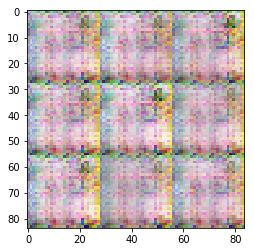

Epoch 1/1... Discriminator Loss: 1.7450... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 2.4372... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 2.8639... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 2.0984... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 2.2965... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 1.6660... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.7598... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.8606... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 2.2064... Generator Loss: 0.9190


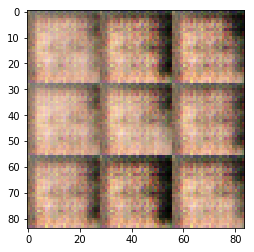

Epoch 1/1... Discriminator Loss: 1.9693... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.7912... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 2.2732... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.9966... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.8976... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 2.0825... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.7776... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 2.0539... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.7518... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.6707


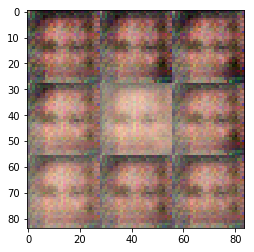

Epoch 1/1... Discriminator Loss: 1.7274... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.8200... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.8475... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 1.7063... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.9900


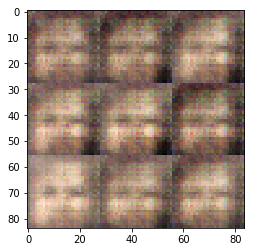

Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.9160... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.7093... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.6336... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.9941


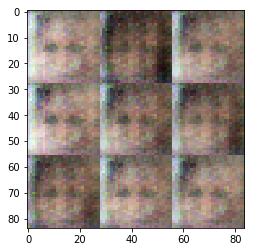

Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.6525... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.6321... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.6320... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.7066... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.6271... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.7434... Generator Loss: 0.6454


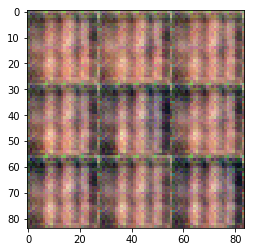

Epoch 1/1... Discriminator Loss: 1.8989... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.7603... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.6311... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.7634... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.9024


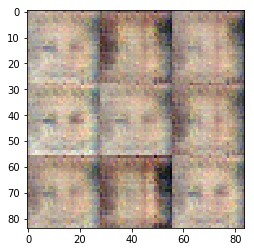

Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.6062... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.7035... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.6203... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.7794... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.9321
Epoch 1/1.

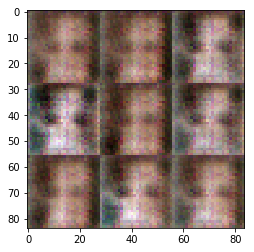

Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.7871... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.6909


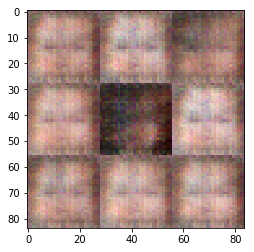

Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.5597


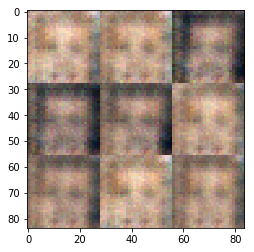

Epoch 1/1... Discriminator Loss: 1.6415... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.6590... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.6132... Generator Loss: 0.6782


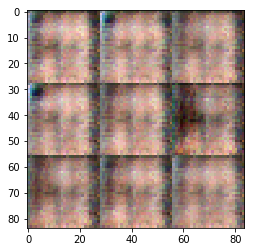

Epoch 1/1... Discriminator Loss: 1.9159... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.5892... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.5944... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.7096


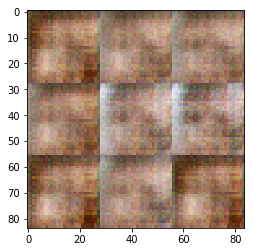

Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.9091... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.9401... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.5718... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7337


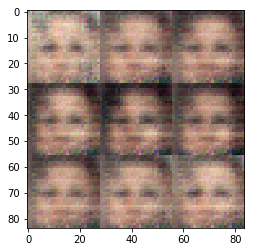

Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7950


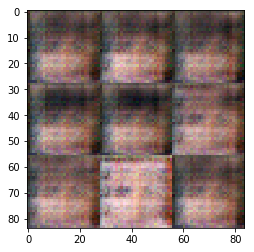

Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.7289... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.6212... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.8483... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.7362... Generator Loss: 0.5426


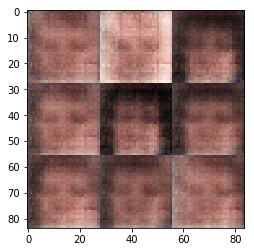

Epoch 1/1... Discriminator Loss: 1.7232... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.7052... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.8521... Generator Loss: 0.6050


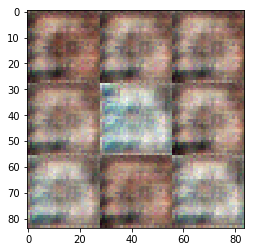

Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.6906... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.8780... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.7874... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 1.0592
Epoch 1/1... Discriminator Loss: 1.6552... Generator Loss: 0.6938


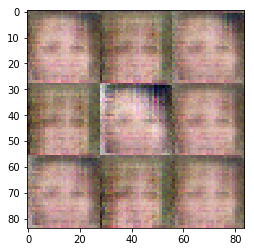

Epoch 1/1... Discriminator Loss: 1.5822... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.5516


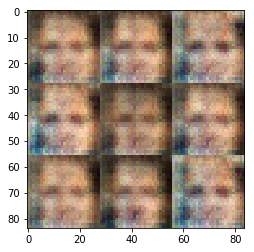

Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.6002... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.5845... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.7952


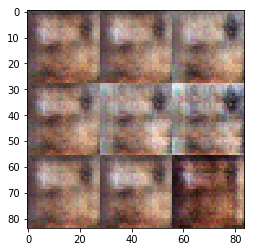

Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.7070... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7278


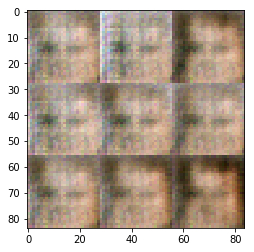

Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.5710... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.5669... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.5918... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.5672


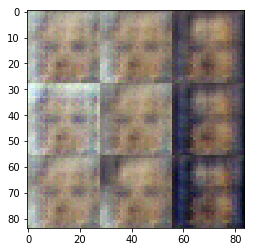

Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.6113... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.6831


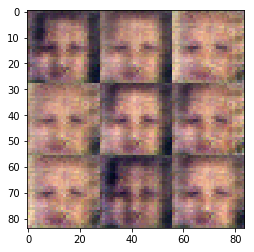

Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.6021


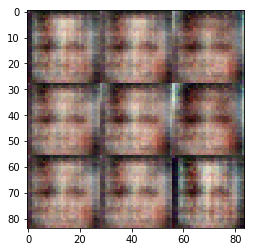

Epoch 1/1... Discriminator Loss: 1.6226... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.6484... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.7637... Generator Loss: 0.6820


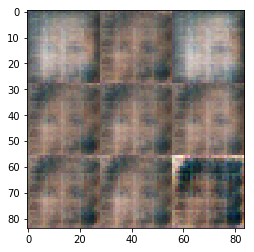

Epoch 1/1... Discriminator Loss: 1.6212... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.6916... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.6535... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6491


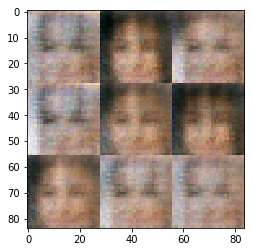

Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 0.6321


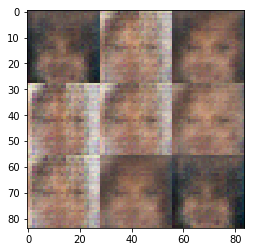

Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.6020... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.6866


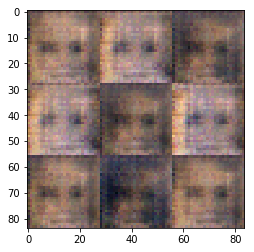

Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.5925... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 0.6335


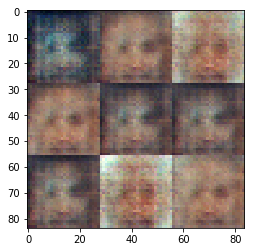

Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.6149... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6279


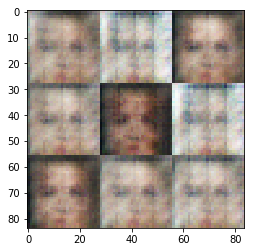

Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.6656


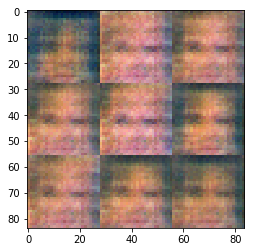

Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.5644... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.6608


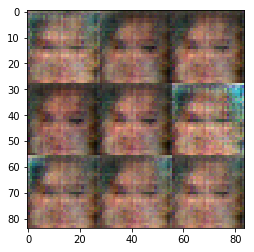

Epoch 1/1... Discriminator Loss: 1.6161... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.6393... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6409


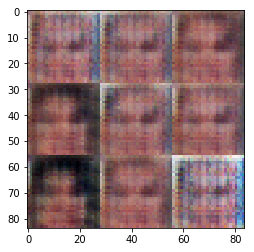

Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.6497... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7034


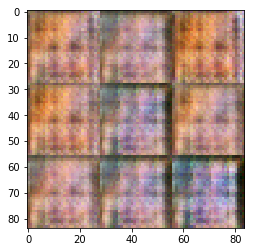

Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6651


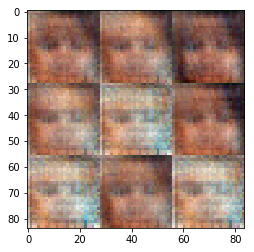

Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8218


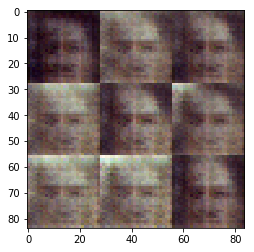

Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6882


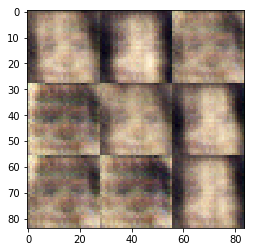

Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.6464... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.7133


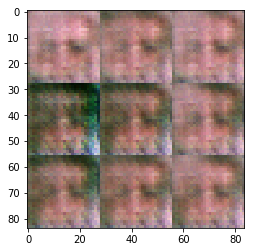

Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7374


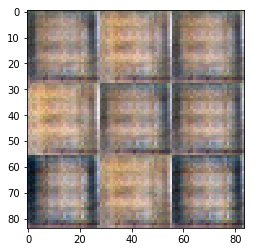

Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6511


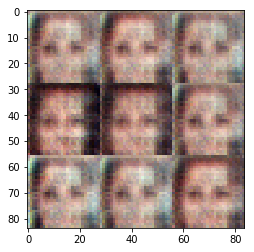

Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.6252... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6889


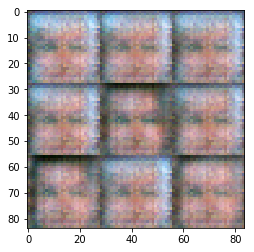

Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6567


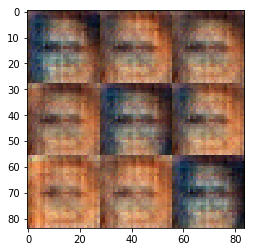

Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7001


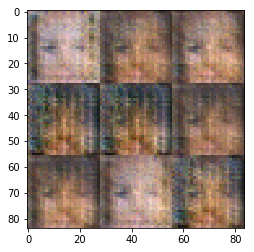

Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.5725... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.5981... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7053


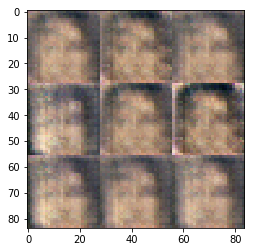

Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7075


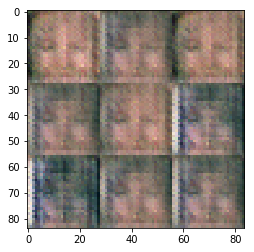

Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7215


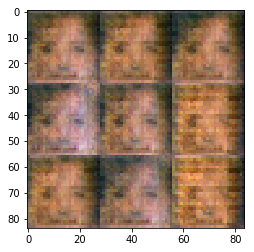

Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.5928


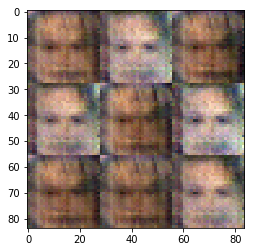

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.7588


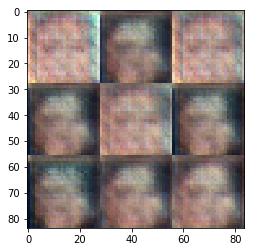

Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7376


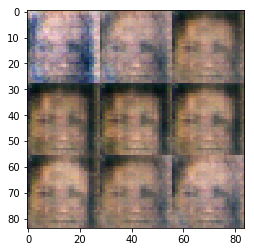

Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.7083


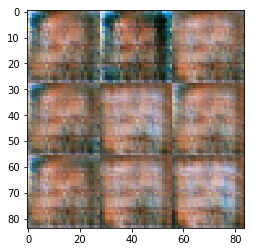

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.6872


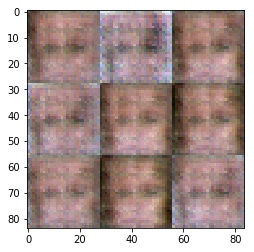

Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6246


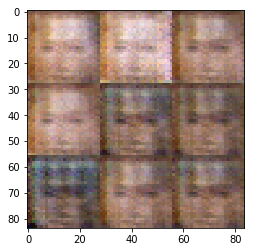

Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.7355


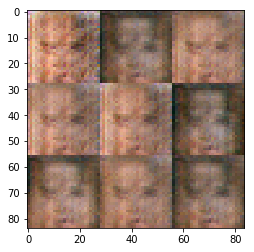

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6745


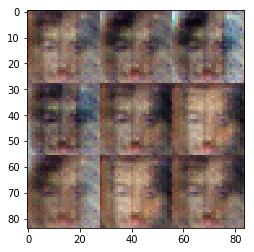

Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7779


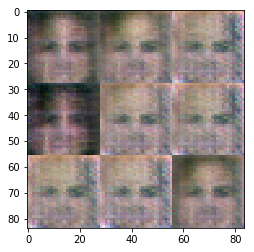

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6112


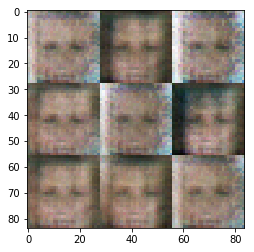

Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.6185


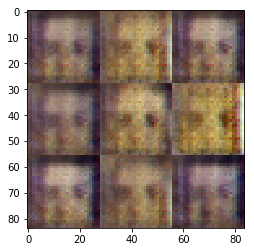

Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7676


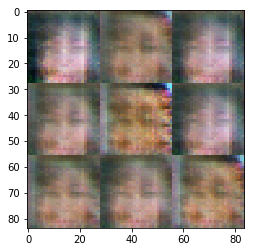

Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.6438... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6779


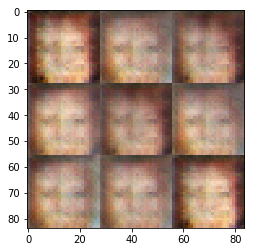

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7248


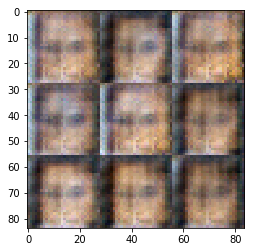

Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.7440


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.